In [ ]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,models
from torchvision.models import VGG19_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])


In [ ]:
!unzip -qq ./chip_data.zip -d data

In [ ]:
dataset_path='./data/dataset'
train_dataset=datasets.ImageFolder(root=f"{dataset_path}/train",transform=transform)
test_dataset=datasets.ImageFolder(root=f"{dataset_path}/test",transform=transform)

In [ ]:
def show_sample_images(dataset,num_images=5):
  fig,axes=plt.subplots(1,num_images,figsize=(5,5))
  for i in range(num_images):
    image,label=dataset[i]
    image=image.permute(1,2,0)
    axes[i].imshow(image)
    axes[i].set_title(dataset.classes[label])
    axes[i].axis("off")
  plt.show()

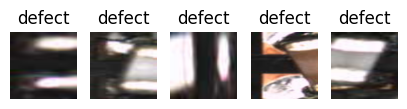

In [ ]:
show_sample_images(train_dataset)

In [ ]:
print("Number of training samples:",len(train_dataset))
first_image,label=train_dataset[0]
print("Image shape:",first_image.shape)

print("Number of testing samples:",len(test_dataset))
first_image1,label=test_dataset[0]
print("Image shape:",first_image1.shape)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)


Number of training samples: 172
Image shape: torch.Size([3, 224, 224])
Number of testing samples: 121
Image shape: torch.Size([3, 224, 224])


In [ ]:
model=models.vgg19(weights=VGG19_Weights.DEFAULT)
device=t.device("cuda" if t.cuda.is_available() else "cpu")
model=model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.5MB/s]


In [ ]:
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model.classifier[-1]=nn.Linear(model.classifier[-1].in_features,1)
device=t.device("cuda" if t.cuda.is_available() else "cpu")
model=model.to(device)

In [ ]:
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
for param in model.features.parameters():
  param.requires_grad=False

criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train_model(model,train_loader,test_loader,num_epochs=100):
  train_losses=[]
  val_losses=[]
  for epoch in range(num_epochs):
    running_loss=0.0
    for images,labels in train_loader:
      images,labels=images.to(device),labels.to(device)
      optimizer.zero_grad()
      outputs=model(images)
      loss=criterion(outputs,labels.unsqueeze(1).float())
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
    train_losses.append(running_loss/len(train_loader))

    model.eval()
    val_loss=0.0
    with t.no_grad():
      for images,labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        outputs=model(images)
        loss=criterion(outputs,labels.unsqueeze(1).float())
        val_loss+=loss.item()
    val_losses.append(val_loss/len(test_loader))
    model.train()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
  plt.figure(figsize=(8,6))
  plt.plot(range(1,num_epochs+1),train_losses,label="Train Loss",marker="o")
  plt.plot(range(1,num_epochs+1),val_losses,label="Validation Loss",marker="s")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and validation Loss")
  plt.legend()
  plt.show()
  print("Name: Vikaash K S")
  print("Register Number 212223240179")

Epoch [1/100], Train Loss: 0.3803, Validation Loss: 0.1463
Epoch [2/100], Train Loss: 0.1378, Validation Loss: 0.6400
Epoch [3/100], Train Loss: 0.1006, Validation Loss: 0.3323
Epoch [4/100], Train Loss: 0.1086, Validation Loss: 0.0850
Epoch [5/100], Train Loss: 0.0022, Validation Loss: 0.1324
Epoch [6/100], Train Loss: 0.0009, Validation Loss: 0.1917
Epoch [7/100], Train Loss: 0.0002, Validation Loss: 0.1666
Epoch [8/100], Train Loss: 0.0030, Validation Loss: 0.1038
Epoch [9/100], Train Loss: 0.0004, Validation Loss: 0.0794
Epoch [10/100], Train Loss: 0.0009, Validation Loss: 0.1671
Epoch [11/100], Train Loss: 0.0004, Validation Loss: 0.2105
Epoch [12/100], Train Loss: 0.0000, Validation Loss: 0.1544
Epoch [13/100], Train Loss: 0.0000, Validation Loss: 0.1223
Epoch [14/100], Train Loss: 0.0007, Validation Loss: 0.2394
Epoch [15/100], Train Loss: 0.0006, Validation Loss: 0.3577
Epoch [16/100], Train Loss: 0.0000, Validation Loss: 0.2129
Epoch [17/100], Train Loss: 0.0000, Validation Lo

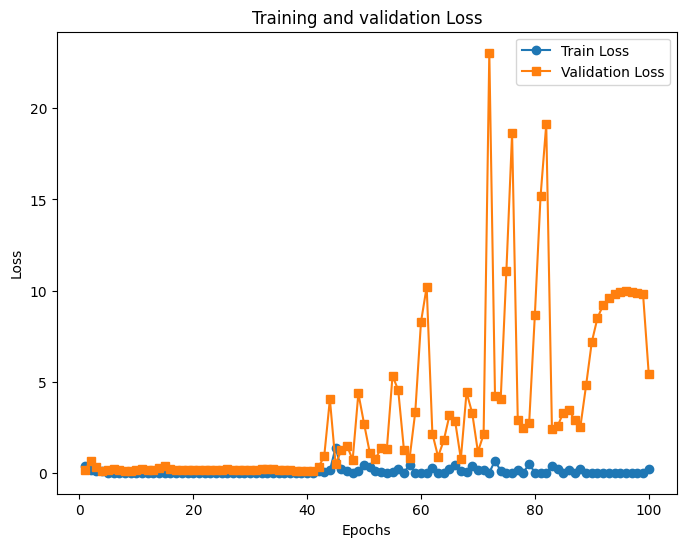

Name: Vikaash K S
Register Number 212223240179


In [ ]:
device=t.device("cuda" if t.cuda.is_available() else "cpu")
model=model.to(device)
train_model(model,train_loader,test_loader)

In [ ]:
def test_model(model,test_loader):
  model.eval()
  correct=0
  total=0
  all_preds=[]
  all_labels=[]

  with t.no_grad():
    for images,labels in test_loader:
      images=images.to(device)
      labels=labels.float().unsqueeze(1).to(device)

      outputs=model(images)
      probs=t.sigmoid(outputs)
      predicted=(probs > 0.5).int()
      total+=labels.size(0)
      correct+=(predicted==labels.int()).sum().item()

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy().astype(int))
  accuracy=correct/total
  print(f"Test Accuracy: {accuracy:.4f}")

  class_names=['Negative','Positive']
  cm=confusion_matrix(all_labels,all_preds)
  plt.figure(figsize=(6,5))
  sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print("Name : Vikaash K S")
  print("Register Number : 212223240179")
  print("Classification Report :")
  print(classification_report(all_labels,all_preds,target_names=class_names))


Test Accuracy: 0.9587


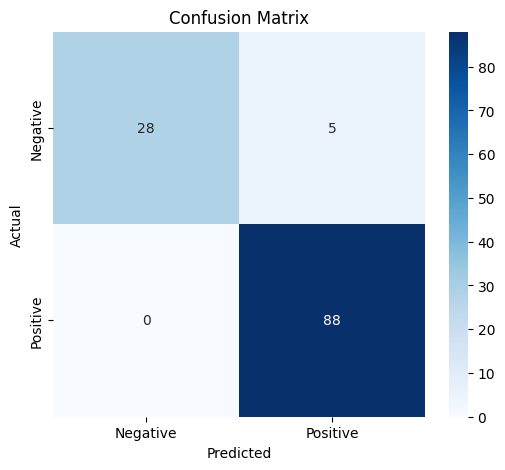

Name : Vikaash K S
Register Number : 212223240179
Classification Report :
              precision    recall  f1-score   support

    Negative       1.00      0.85      0.92        33
    Positive       0.95      1.00      0.97        88

    accuracy                           0.96       121
   macro avg       0.97      0.92      0.95       121
weighted avg       0.96      0.96      0.96       121



In [ ]:
test_model(model,test_loader)

In [ ]:
def predict_image(model,image_index,dataset):
  model.eval()
  image,label=dataset[image_index]
  with t.no_grad():
    image_tensor = image.unsqueeze(0).to(device)
    output=model(image_tensor)
    _,predicted=t.max(output,1)
  class_names=dataset.classes

  image_to_display=transforms.ToPILImage()(image)
  print("Name : Vikaash K S")
  print("Register Number : 212223240179")
  plt.figure(figsize=(4,4))
  plt.imshow(image_to_display)
  plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
  plt.axis('off')
  plt.show()

Name : Vikaash K S
Register Number : 212223240179


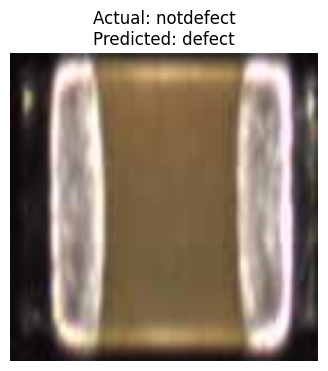

In [ ]:
predict_image(model,image_index=55,dataset=test_dataset)

Name : Vikaash K S
Register Number : 212223240179


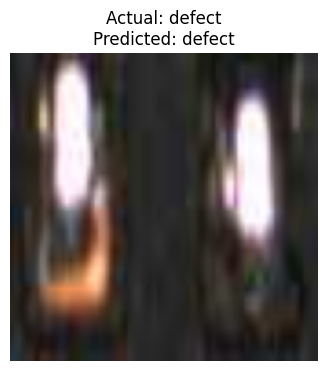

In [ ]:
predict_image(model,image_index=25,dataset=test_dataset)